<a href="https://colab.research.google.com/github/dinbav/SpreadingKnowledge/blob/master/modeling_with_probs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##installs

In [18]:
!pip install CatBoost

In [19]:
!pip install category_encoders

In [20]:
!pip install shap

In [21]:
!pip install mlflow

##imports

In [22]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import StandardScaler#, PolynomialFeatures, MinMaxScaler, Normalizer

import matplotlib.pyplot as plt
import shap
import mlflow
from sklearn import preprocessing

In [23]:
import numpy as np
import pandas as pd


In [24]:
from catboost import CatBoostClassifier, Pool, cv
import category_encoders as ce

In [25]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

##Functions

In [26]:
def extract_threshold_given_recall(y_test, probabilities, given_recall):
    p, r, t = precision_recall_curve(y_test, probabilities)
    idx = np.abs(r - given_recall).argmin()
    return t[idx]

In [27]:

def find_best_threshold(thresholds, fpr, tpr, manual_th=0.5):
    """
    find the best threshold from the roc curve. by finding the threshold
    for the point which is closest to (fpr=0,tpr=1)
    :param thresholds: cut off threshold range for predict probabilities
    :param fpr: false positive rate
    :param tpr: true positive rate
    :param manual_th: manuel threshold to replace calculated threshold
    :return: the best threshold which trying to minimize fpr and maximize tpr
    """
    if manual_th < 1 and manual_th > 0:
        return manual_th
    else:
        fpr_tpr = pd.DataFrame({'thresholds': thresholds, 'fpr': fpr, 'tpr': tpr})
        fpr_tpr['dist'] = (fpr_tpr['fpr']) ** 2 + (fpr_tpr['tpr'] - 1) ** 2

    return fpr_tpr.iloc[fpr_tpr.dist.idxmin(), 0]


In [28]:
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):

    """
    Pretty print for confusion matrix
    :param cm:
    :param labels:
    :param hide_zeroes:
    :param hide_diagonal:
    :param hide_threshold:
    :return: pretty print for confusion matrix
    """

    colwidth = 6
    empty_cell = " " * colwidth
    # Begin CHANGES
    fst_empty_cell = (colwidth - 3) // 2 * " " + "T\P" + (colwidth - 3) // 2 * " "
    if len(fst_empty_cell) < len(empty_cell):
        fst_empty_cell = " " * (len(empty_cell) - len(fst_empty_cell)) + fst_empty_cell
    # Print header
    print("    " + fst_empty_cell, end=" ")
    # End CHANGES
    for label in labels:
        print("%{0}s".format(colwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(colwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.0f".format(colwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [29]:
def plot_model(model, X_train, y_train, X_test, y_test):

  probabilities = model.predict_proba(X_test)[:, 1]


  fpr, tpr, thresholds = metrics.roc_curve(y_test, probabilities)    
  plt.figure()
  plt.plot(fpr, tpr, label='test')
  roc_auc_test=round(metrics.roc_auc_score(y_test, probabilities), 4)
  train_probabilities = model.predict_proba(X_train)[:,1]
  fpr, tpr, thresholds = metrics.roc_curve(y_train, train_probabilities)
  
  plt.plot(fpr, tpr, label='train')
  plt.plot([0, 1], [0, 1], 'r--', label='random guess')
  plt.title("Area under the ROC = {}".format(roc_auc_test), fontsize=18)
  plt.legend()
  plt.show()

  rcl_per_disp = metrics.plot_precision_recall_curve(model, X_test, y_test)
  plt.show()

  roc_disp = metrics.plot_roc_curve(model, X_test, y_test)
  plt.cla()
  plt.clf()
  plt.close()

  X_train = pd.DataFrame(X_train)

  xtrain_samp = X_train.sample(frac = 0.5, random_state=1)
  %time 
  shap_values = shap.TreeExplainer(model).shap_values(xtrain_samp)
  shap.summary_plot(shap_values, xtrain_samp)

In [30]:
def model_probs_preds(probabilities, threshold, y_test):
    predictions = probabilities > threshold
    print('****************************************************')

    labels = [0, 1]
    cm = metrics.confusion_matrix(y_test, predictions)

    print('Confusion Matrix=')
    print_cm(cm, labels)
    print('classification_report=')
    print(metrics.classification_report(y_test, predictions, digits=3, target_names=['0', '1']))
    print('FPR:', "{0:.2%}".format(round(metrics.confusion_matrix(y_test, predictions)[0, 1] /
                                         (metrics.confusion_matrix(y_test, predictions)[0, 1]
                                          + metrics.confusion_matrix(y_test, predictions)[0, 0]), 4)))
    roc_auc_test=round(metrics.roc_auc_score(y_test, probabilities), 4)
    print('AUC:', "{0:.2%}".format(roc_auc_test))
    print('Accuracy Score:', "{0:.2%}".format(round(metrics.accuracy_score(y_test, predictions), 4)))
    print('Best Threshold:', "{0:.2%}".format(round(threshold, 4)))
    print('****************************************************')

In [31]:
def get_model_results_for_recall(model, X_test, y_test, X_train, y_train, given_recall, with_plots = True):
    """
    Get a summary of model results as follow:
    ****************************************************
    Confusion Matrix=
          T\P       0      1
             0 148328  27376
             1   5397  25233
    classification_report=
                  precision    recall  f1-score   support
               0      0.965     0.844     0.901    175704
               1      0.480     0.824     0.606     30630
        accuracy                          0.841    206334
       macro avg      0.722     0.834     0.753    206334
    weighted avg      0.893     0.841     0.857    206334
    FPR: 15.58%
    AUC: 91.53%
    Accuracy Score: 84.12%
    Best Threshold: 48.55%
    Traffic to buy: 0.12%
    ****************************************************
    :param model:
    :param X_test:
    :param y_test:
    :param X_train:
    :param y_train:
    :param manual_th:
    :param with_plots:
    :return: printed summary of model results
    """

    probabilities = model.predict_proba(X_test)[:, 1]
    #fpr, tpr, thresholds = metrics.roc_curve(y_test, probabilities)
    threshold = extract_threshold_given_recall(y_test, probabilities, given_recall)

    predictions = probabilities > threshold
    print('****************************************************')

    
    labels = [0, 1]
    cm = metrics.confusion_matrix(y_test, predictions)
    tn, fp, fn, tp = cm.ravel()
    traffic_to_buy = (fp + tp)/(tn + fp + fn + tp)

    print('Confusion Matrix=')
    print_cm(cm, labels)
    print('classification_report=')
    print(metrics.classification_report(y_test, predictions, digits=3, target_names=['0', '1']))
    print('FPR:', "{0:.2%}".format(round(metrics.confusion_matrix(y_test, predictions)[0, 1] /
                                         (metrics.confusion_matrix(y_test, predictions)[0, 1]
                                          + metrics.confusion_matrix(y_test, predictions)[0, 0]), 4)))
    roc_auc_test=round(metrics.roc_auc_score(y_test, probabilities), 4)
    print('AUC:', "{0:.2%}".format(roc_auc_test))
    print('Accuracy Score:', "{0:.2%}".format(round(metrics.accuracy_score(y_test, predictions), 4)))
    print('Best Threshold:', "{0:.2%}".format(round(threshold, 4)))
    print('Traffic to buy:', "{0:.2%}".format(round(traffic_to_buy, 4)))
    print('****************************************************')

    

    
    if with_plots:
      

      plot_model(model, X_train, y_train, X_test, y_test)  

    return df_with_target_probs(model, X_train, y_train, X_test, y_test)   

In [32]:
def get_model_results(model, X_test, y_test, X_train, y_train, manual_th=-9, with_plots = True):
    """
    Get a summary of model results as follow:
    ****************************************************
    Confusion Matrix=
          T\P       0      1
             0 148328  27376
             1   5397  25233
    classification_report=
                  precision    recall  f1-score   support
               0      0.965     0.844     0.901    175704
               1      0.480     0.824     0.606     30630
        accuracy                          0.841    206334
       macro avg      0.722     0.834     0.753    206334
    weighted avg      0.893     0.841     0.857    206334
    FPR: 15.58%
    AUC: 91.53%
    Accuracy Score: 84.12%
    Best Threshold: 48.55%
    ****************************************************
    :param model:
    :param X_test:
    :param y_test:
    :param X_train:
    :param y_train:
    :param manual_th:
    :param with_plots:
    :return: printed summary of model results
    """

    probabilities = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, probabilities)
    threshold = find_best_threshold(thresholds, fpr, tpr,manual_th)
    
    model_probs_preds(probabilities, threshold, y_test) 


    
    if with_plots:

      plot_model(model, X_train, y_train, X_test, y_test)

    df = df_with_target_probs(model, X_train, y_train, X_test, y_test)
    return df






In [33]:
def df_with_target_probs(model, X_train, y_train, X_test, y_test):
  train = pd.DataFrame(X_train)
  test = pd.DataFrame(X_test)
  
  test['probabilities'] = pd.Series(model.predict_proba(X_test)[:,1])
  train['probabilities'] = pd.Series(model.predict_proba(X_train)[:,1])



  train['y_true'] =  pd.Series(y_train.flatten())
  test['y_true'] =  pd.Series(y_test.flatten())

  
  test['y_pred'] =  pd.Series(model.predict(X_train))

  df = train.append(test).sort_index()

  return df


## How to use

### Creating a dataframe with the probabilities 

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer




dataset = load_breast_cancer()
X = dataset.data
y = dataset.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

RFmodel = RandomForestClassifier(n_estimators=100)  # Choose a model here


RFmodel.fit(X_train, y_train)

df = df_with_target_probs(RFmodel, X_train, y_train, X_test, y_test)

df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,probabilities,y_true,y_pred
0,11.85,17.46,75.54,432.7,0.08372,0.05642,0.026880,0.022800,0.1875,0.05715,0.2070,1.2380,1.234,13.88,0.007595,0.015000,0.014120,0.008578,0.01792,0.001784,13.06,25.75,84.35,517.8,0.1369,0.17580,0.13160,0.09140,0.3101,0.07007,1.00,1,NaN
0,13.40,20.52,88.64,556.7,0.11060,0.14690,0.144500,0.081720,0.2116,0.07325,0.3906,0.9306,3.093,33.67,0.005414,0.022650,0.034520,0.013340,0.01705,0.004005,16.41,29.66,113.30,844.4,0.1574,0.38560,0.51060,0.20510,0.3585,0.11090,0.00,0,1.0
1,13.21,25.25,84.10,537.9,0.08791,0.05205,0.027720,0.020680,0.1619,0.05584,0.2084,1.3500,1.314,17.58,0.005768,0.008082,0.015100,0.006451,0.01347,0.001828,14.35,34.23,91.29,632.9,0.1289,0.10630,0.13900,0.06005,0.2444,0.06788,0.94,1,1.0
1,11.22,19.86,71.94,387.3,0.10540,0.06779,0.005006,0.007583,0.1940,0.06028,0.2976,1.9660,1.959,19.62,0.012890,0.011040,0.003297,0.004967,0.04243,0.001963,11.98,25.78,76.91,436.1,0.1424,0.09669,0.01335,0.02022,0.3292,0.06522,1.00,1,NaN
2,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.144000,0.097910,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.024230,0.039500,0.016780,0.01898,0.002498,23.69,38.25,155.00,1731.0,0.1166,0.19220,0.32150,0.16280,0.2572,0.06637,0.00,0,NaN


### Plotting model evaluation plots Creating and retrieving a dataframe with the probabilities

****************************************************
Confusion Matrix=
      T\P       0      1 
         0     52      1 
         1      3     87 
classification_report=
              precision    recall  f1-score   support

           0      0.945     0.981     0.963        53
           1      0.989     0.967     0.978        90

    accuracy                          0.972       143
   macro avg      0.967     0.974     0.970       143
weighted avg      0.973     0.972     0.972       143

FPR: 1.89%
AUC: 99.66%
Accuracy Score: 97.20%
Best Threshold: 47.00%
****************************************************


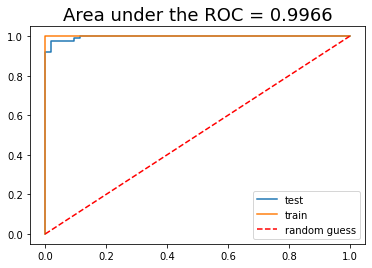

Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.


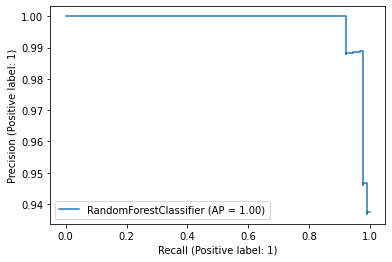

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10.5 µs


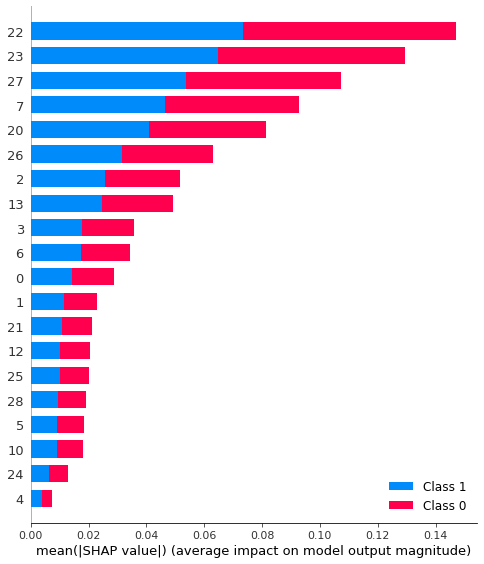

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,probabilities,y_true,y_pred
0,11.85,17.46,75.54,432.7,0.08372,0.05642,0.026880,0.022800,0.1875,0.05715,0.2070,1.2380,1.234,13.88,0.007595,0.015000,0.014120,0.008578,0.01792,0.001784,13.06,25.75,84.35,517.8,0.1369,0.17580,0.13160,0.09140,0.3101,0.07007,1.00,1,NaN
0,13.40,20.52,88.64,556.7,0.11060,0.14690,0.144500,0.081720,0.2116,0.07325,0.3906,0.9306,3.093,33.67,0.005414,0.022650,0.034520,0.013340,0.01705,0.004005,16.41,29.66,113.30,844.4,0.1574,0.38560,0.51060,0.20510,0.3585,0.11090,0.05,0,1.0
1,13.21,25.25,84.10,537.9,0.08791,0.05205,0.027720,0.020680,0.1619,0.05584,0.2084,1.3500,1.314,17.58,0.005768,0.008082,0.015100,0.006451,0.01347,0.001828,14.35,34.23,91.29,632.9,0.1289,0.10630,0.13900,0.06005,0.2444,0.06788,0.96,1,1.0
1,11.22,19.86,71.94,387.3,0.10540,0.06779,0.005006,0.007583,0.1940,0.06028,0.2976,1.9660,1.959,19.62,0.012890,0.011040,0.003297,0.004967,0.04243,0.001963,11.98,25.78,76.91,436.1,0.1424,0.09669,0.01335,0.02022,0.3292,0.06522,1.00,1,NaN
2,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.144000,0.097910,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.024230,0.039500,0.016780,0.01898,0.002498,23.69,38.25,155.00,1731.0,0.1166,0.19220,0.32150,0.16280,0.2572,0.06637,0.00,0,NaN


In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer


dataset = load_breast_cancer()
X = dataset.data
y = dataset.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


RFmodel = RandomForestClassifier(n_estimators=100)  # Choose a model here
RFmodel.fit(X_train, y_train)

df_probs = get_model_results(RFmodel, X_test, y_test, X_train, y_train, manual_th=-9)

df_probs.head()